In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd "/content/drive/My Drive/forest-cover-type-kernels-only"
!ls

/content/drive/My Drive/forest-cover-type-kernels-only
best_model1.h5	       sub_CNN.csv		 Submission4.csv
CNN_normalized.csv     sub_ensemble_forest1.csv  test.csv
Forest-cover.ipynb     sub_ensemble_forest2.csv  train.csv
sample_submission.csv  Submission3.csv


In [4]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import backend as K

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import io
%matplotlib inline

Using TensorFlow backend.


In [0]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB, MultinomialNB,  BernoulliNB
from sklearn.metrics import accuracy_score, log_loss,jaccard_similarity_score
import math
from sklearn.preprocessing import normalize

import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [48]:
!pip install heamy

  Stored in directory: /root/.cache/pip/wheels/ab/05/27/334fcc59e6279e70d84880e6988ea934d740829a900f14352f
Successfully built heamy


In [0]:
import logging
from heamy.dataset import Dataset
from heamy.estimator import Classifier
from heamy.pipeline import ModelsPipeline

In [0]:
CACHE=False

NFOLDS = 5
SEED = 1337
METRIC = log_loss

ID = 'Id'
TARGET = 'Cover_Type'

np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

np.random.seed(SEED)
#logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.WARNING)

In [0]:
def extra_ftr(train_df):
  print("starting extra_ftr")
  
  train_df['HF1'] = train_df['Horizontal_Distance_To_Hydrology']+train_df['Horizontal_Distance_To_Fire_Points']
  train_df['HF2'] = abs(train_df['Horizontal_Distance_To_Hydrology']-train_df['Horizontal_Distance_To_Fire_Points'])
  train_df['HR1'] = abs(train_df['Horizontal_Distance_To_Hydrology']+train_df['Horizontal_Distance_To_Roadways'])
  train_df['HR2'] = abs(train_df['Horizontal_Distance_To_Hydrology']-train_df['Horizontal_Distance_To_Roadways'])
  train_df['FR1'] = abs(train_df['Horizontal_Distance_To_Fire_Points']+train_df['Horizontal_Distance_To_Roadways'])
  train_df['FR2'] = abs(train_df['Horizontal_Distance_To_Fire_Points']-train_df['Horizontal_Distance_To_Roadways'])
  train_df['ele_vert'] = train_df.Elevation-train_df.Vertical_Distance_To_Hydrology

  train_df['slope_hyd'] = (train_df['Horizontal_Distance_To_Hydrology']**2+train_df['Vertical_Distance_To_Hydrology']**2)**0.5
  train_df.slope_hyd=train_df.slope_hyd.map(lambda x: 0 if np.isinf(x) else x) # remove infinite value if any

  #Mean distance to Amenities 
  train_df['Mean_Amenities']=(train_df.Horizontal_Distance_To_Fire_Points + train_df.Horizontal_Distance_To_Hydrology + train_df.Horizontal_Distance_To_Roadways) / 3 
  #Mean Distance to Fire and Water 
  train_df['Mean_Fire_Hyd']=(train_df.Horizontal_Distance_To_Fire_Points + train_df.Horizontal_Distance_To_Hydrology) / 2 
  
  return train_df

In [0]:
from sklearn import preprocessing

def normaalize(train_df):
  scaler = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=False).fit(train_df)
  scaler.transform(train_df)
  return train_df

Run the code blocks  below for CNN model

In [7]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print("train and test df loaded ")

train_lbl = train_df['Cover_Type']
#train_df = soil_ftr(train_df)
#train_df = wild_ftr(train_df)
train_df = extra_ftr(train_df)

#test_df = soil_ftr(test_df)
#test_df = wild_ftr(test_df)
test_df = extra_ftr(test_df) 

train_df.drop(['Id','Cover_Type','Elevation'],axis=1,inplace=True)
test_df.drop(['Id','Elevation'],axis=1,inplace=True)

train_df=np.array(train_df)
test_df=np.array(test_df)

train_df=normaalize(train_df)
test_df=normaalize(test_df)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_df, train_lbl, test_size=0.3, random_state=42)

train and test df loaded 
starting extra_ftr
starting extra_ftr


In [0]:
from keras.utils import to_categorical

y_train=y_train-1
y_val=y_val-1

y_train=to_categorical(y_train)
y_val=to_categorical(y_val)


In [9]:
print("Shape of y_train : ",y_train.shape)
print("Shape of y_val : ",y_val.shape)

print("Shape of X_train : ",X_train.shape)
print("Shape of X_val : ",X_val.shape)

print(y_val[0])

Shape of y_train :  (10584, 7)
Shape of y_val :  (4536, 7)
Shape of X_train :  (10584, 63)
Shape of X_val :  (4536, 63)
[0. 0. 0. 0. 0. 1. 0.]


In [23]:
from keras.layers import Activation

batch_size = 256
epochs = 30
img_cols, channels = 63 , 1

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], channels, img_cols)
    X_val = X_val.reshape(X_val.shape[0], channels, img_cols)
    input_shape = (channels, img_cols, )
else:
    X_train = X_train.reshape(X_train.shape[0], img_cols, channels)
    X_val = X_val.reshape(X_val.shape[0], img_cols, channels)
    input_shape = (img_cols, channels, )

#input_shape = ( 63,1  )   
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')

X_train shape: (10584, 63, 1)
10584 train samples


In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, Conv2D, GRU, CuDNNGRU, CuDNNLSTM, BatchNormalization, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten, AveragePooling1D
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

In [0]:
def build_model1(inp_dim, model_num, kernel_size1, kernel_size2, conv_size, dense_units):
  if model_num==1:
    file_path = "best_model1.h5"
    
  if model_num==2:
    file_path = "best_model2.h5"
  
  if model_num==3:
    file_path = "best_model3.h5"
    
  if model_num==4:
    file_path = "best_model4.h5"
  
  best_model = ModelCheckpoint(file_path, monitor='val_acc', verbose = 1, save_best_only = True)
  callbacks = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
  
  inp=Input(shape = input_shape)
  
  x1 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform', activation='relu')(inp)
  x1 = Conv1D(2*conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform', activation='relu')(x1)
  x1 = BatchNormalization()(x1)
  x1 = Conv1D(4*conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform', activation='relu')(x1)
  x1 = Conv1D(8*conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform', activation='relu')(x1)
  x1 = AveragePooling1D()(x1)
  
  
  x2 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform',activation='relu')(inp)
  x2 = Conv1D(2*conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x2)
  x2 = BatchNormalization()(x2)
  x2 = Conv1D(4*conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform',activation='relu')(x2)
  x2 = Conv1D(8*conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform',activation='relu')(x2)
  x2 = MaxPooling1D()(x2)
  '''
  
  x3 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(inp)
  x3 = Conv1D(2*conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x3)
  x3 = MaxPooling1D()(x3)
  x3 = Conv1D(4*conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x3)
  x3 = Conv1D(8*conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x3)
  x3 = AveragePooling1D()(x3)
  
  x4 = Conv1D(conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(inp)
  x4 = Conv1D(2*conv_size, kernel_size=kernel_size1, padding='valid', kernel_initializer='he_uniform')(x4)
  x4 = MaxPooling1D()(x4)
  x4 = Conv1D(4*conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x4)
  x4 = Conv1D(8*conv_size, kernel_size=kernel_size2, padding='valid', kernel_initializer='he_uniform')(x4)
  x4 = MaxPooling1D()(x4)
  '''
  
  x = concatenate([x1, x2])
  print("After concatenate : ",x.shape)
  x =Flatten()(x)
  print("After Flatten : ",x.shape)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(Dense(dense_units, activation='relu') (x))
  print("After dense1 : ",x.shape)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(Dense(int(dense_units / 2), activation='relu') (x))
  print("After dense2 : ",x.shape)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(Dense(int(dense_units / 4), activation='relu') (x))
  print("After dense3 : ",x.shape)
  x = Dense(7, activation = "softmax")(x)
  print("After dense4 : ",x.shape)
  model = Model(inputs = inp, outputs = x)
  model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ["accuracy"])
  history = model.fit(X_train, y_train, batch_size = 128, epochs = 70, validation_data=(X_val, y_val), verbose = 1, callbacks = [callbacks,best_model])
  print(model.summary())
  
  
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  
  return model

After concatenate :  (?, 27, 256)
After Flatten :  (?, ?)
After dense1 :  (?, 256)
After dense2 :  (?, 128)
After dense3 :  (?, 64)
After dense4 :  (?, 7)
Train on 10584 samples, validate on 4536 samples
Epoch 1/70
10584/10584 [==============================] - 7s 634us/step - loss: 1.0998 - acc: 0.5670 - val_loss: 0.8251 - val_acc: 0.6523

Epoch 00001: val_acc improved from -inf to 0.65234, saving model to best_model1.h5
Epoch 2/70
10584/10584 [==============================] - 3s 280us/step - loss: 0.8647 - acc: 0.6428 - val_loss: 0.7320 - val_acc: 0.7008

Epoch 00002: val_acc improved from 0.65234 to 0.70084, saving model to best_model1.h5
Epoch 3/70
10584/10584 [==============================] - 3s 259us/step - loss: 0.7500 - acc: 0.6850 - val_loss: 0.6467 - val_acc: 0.7176

Epoch 00003: val_acc improved from 0.70084 to 0.71759, saving model to best_model1.h5
Epoch 4/70
10584/10584 [==============================] - 3s 251us/step - loss: 0.6889 - acc: 0.7112 - val_loss: 0.6163 - va

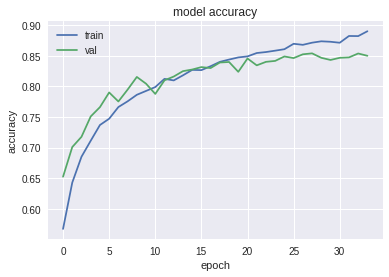

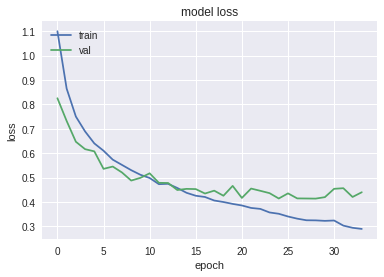

In [31]:
model1=build_model1(inp_dim=63, model_num=1, kernel_size1=3, kernel_size2=3, conv_size=16, dense_units=256)

After concatenate :  (?, 23, 512)
After Flatten :  (?, ?)
After dense1 :  (?, 512)
After dense2 :  (?, 256)
After dense3 :  (?, 128)
After dense4 :  (?, 7)
Train on 10584 samples, validate on 4536 samples
Epoch 1/70
10584/10584 [==============================] - 10s 907us/step - loss: 1.0982 - acc: 0.5608 - val_loss: 0.8881 - val_acc: 0.6301

Epoch 00001: val_acc improved from -inf to 0.63007, saving model to best_model2.h5
Epoch 2/70
10584/10584 [==============================] - 4s 387us/step - loss: 0.9249 - acc: 0.6112 - val_loss: 0.8278 - val_acc: 0.6656

Epoch 00002: val_acc improved from 0.63007 to 0.66556, saving model to best_model2.h5
Epoch 3/70
10584/10584 [==============================] - 4s 378us/step - loss: 0.8019 - acc: 0.6609 - val_loss: 0.7995 - val_acc: 0.6623

Epoch 00003: val_acc did not improve from 0.66556
Epoch 4/70
10584/10584 [==============================] - 4s 390us/step - loss: 0.7223 - acc: 0.6942 - val_loss: 0.8475 - val_acc: 0.6722

Epoch 00004: val_ac

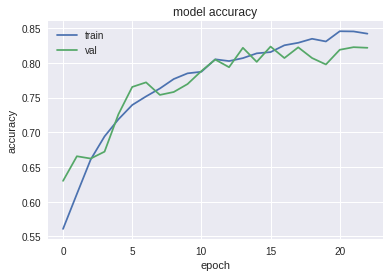

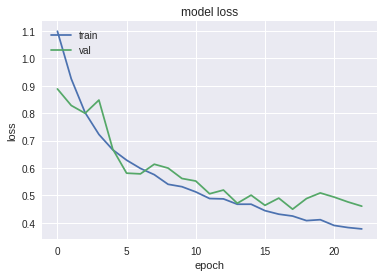

In [37]:
model2=build_model1(inp_dim=63, model_num=2, kernel_size1=5, kernel_size2=5, conv_size=32, dense_units=512)

After concatenate :  (?, 27, 512)
After Flatten :  (?, ?)
After dense1 :  (?, 256)
After dense2 :  (?, 128)
After dense3 :  (?, 64)
After dense4 :  (?, 7)
Train on 10584 samples, validate on 4536 samples
Epoch 1/70
10584/10584 [==============================] - 9s 893us/step - loss: 1.1120 - acc: 0.5622 - val_loss: 0.8196 - val_acc: 0.6550

Epoch 00001: val_acc improved from -inf to 0.65498, saving model to best_model3.h5
Epoch 2/70
10584/10584 [==============================] - 4s 358us/step - loss: 0.8504 - acc: 0.6469 - val_loss: 0.7140 - val_acc: 0.6997

Epoch 00002: val_acc improved from 0.65498 to 0.69974, saving model to best_model3.h5
Epoch 3/70
10584/10584 [==============================] - 4s 347us/step - loss: 0.7467 - acc: 0.6915 - val_loss: 0.6485 - val_acc: 0.7315

Epoch 00003: val_acc improved from 0.69974 to 0.73148, saving model to best_model3.h5
Epoch 4/70
10584/10584 [==============================] - 4s 349us/step - loss: 0.6775 - acc: 0.7180 - val_loss: 0.5841 - va

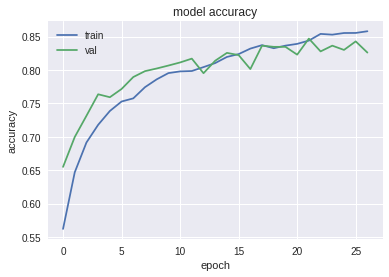

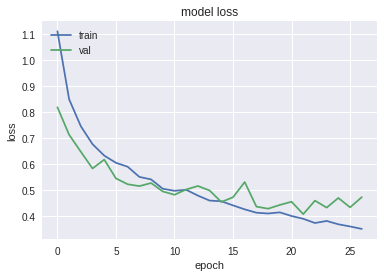

In [38]:
model3=build_model1(inp_dim=63, model_num=3, kernel_size1=3, kernel_size2=3, conv_size=32, dense_units=256)

After concatenate :  (?, 23, 256)
After Flatten :  (?, ?)
After dense1 :  (?, 512)
After dense2 :  (?, 256)
After dense3 :  (?, 128)
After dense4 :  (?, 7)
Train on 10584 samples, validate on 4536 samples
Epoch 1/70
10584/10584 [==============================] - 9s 837us/step - loss: 1.0937 - acc: 0.5629 - val_loss: 0.8839 - val_acc: 0.6168

Epoch 00001: val_acc improved from -inf to 0.61684, saving model to best_model4.h5
Epoch 2/70
10584/10584 [==============================] - 3s 279us/step - loss: 0.9074 - acc: 0.6206 - val_loss: 0.7781 - val_acc: 0.6909

Epoch 00002: val_acc improved from 0.61684 to 0.69092, saving model to best_model4.h5
Epoch 3/70
10584/10584 [==============================] - 3s 277us/step - loss: 0.7968 - acc: 0.6648 - val_loss: 0.7208 - val_acc: 0.6989

Epoch 00003: val_acc improved from 0.69092 to 0.69885, saving model to best_model4.h5
Epoch 4/70
10584/10584 [==============================] - 3s 278us/step - loss: 0.7210 - acc: 0.6938 - val_loss: 0.6392 - v

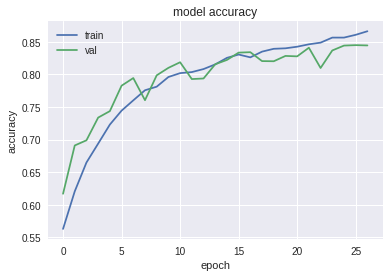

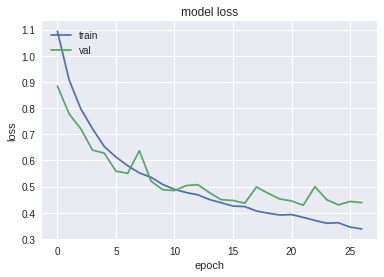

In [39]:
model4=build_model1(inp_dim=63, model_num=4, kernel_size1=5, kernel_size2=5, conv_size=16, dense_units=512)

In [32]:

if K.image_data_format() == 'channels_first':
    X_test = test_df.reshape(test_df.shape[0], channels, img_cols)
    input_shape = (channels, img_cols, )
else:
    X_test = test_df.reshape(test_df.shape[0], img_cols, channels)
    input_shape = (img_cols, channels, )
    
print('X_test shape:', X_test.shape)

X_test shape: (565892, 63, 1)


In [40]:
model1.load_weights('best_model1.h5')
y_pred1=model1.predict(X_test, verbose=1)
#y_pred1=np.argmax(y_pred1, axis = 1)
print(y_pred1.shape)



565892/565892 [==============================] - 93s 164us/step
(565892, 7)


In [41]:
model2.load_weights('best_model2.h5')
y_pred2=model2.predict(X_test, verbose=1)
print(y_pred2.shape)


565892/565892 [==============================] - 123s 218us/step
(565892, 7)


In [42]:
model3.load_weights('best_model3.h5')
y_pred3=model3.predict(X_test, verbose=1)
print(y_pred3.shape)

565892/565892 [==============================] - 119s 210us/step
(565892, 7)


In [43]:
model4.load_weights('best_model4.h5')
y_pred4=model4.predict(X_test, verbose=1)
print(y_pred4.shape)

565892/565892 [==============================] - 99s 174us/step
(565892, 7)


Run the codes below to use Tree Ensemble Model . Note Tree Ensemle model was perfoming much better than CNN Ensemble Model.
On Test Set:
Accuracy of Tree Ensemble Model : 82 %,
Accuracy of CNN Ensemble Model : 70 %,
Accuracy of CNN+Tree Ensemble Model : 80%

In [0]:
def load_and_process_dataset():
    train = pd.read_csv("train.csv")
    test = pd.read_csv("test.csv")

    y_train = train[TARGET].ravel() -1 # XGB needs labels starting with 0!
    
    classes = train.Cover_Type.unique()
    num_classes = len(classes)
    print("There are %i classes: %s " % (num_classes, classes))        

    train.drop([ID, TARGET], axis=1, inplace=True)
    test.drop([ID], axis=1, inplace=True)
    
    train = soil_ftr(train)
    train = wild_ftr(train)
    train = extra_ftr(train)
    
    test = soil_ftr(test)
    test = wild_ftr(test)
    test = extra_ftr(test)    
    
    
    train = train.drop('Elevation', axis=1)
    test = test.drop('Elevation', axis=1)    
    
    x_train = train.values
    x_test = test.values

    return {'X_train': x_train, 'X_test': x_test, 'y_train': y_train}

In [0]:
dataset = Dataset(preprocessor=load_and_process_dataset, use_cache=True)

In [0]:
rf_params = {
    'n_estimators': 200,
    'criterion': 'entropy',
    'random_state': 0
}

rf1_params = {
    'n_estimators': 200,
    'criterion': 'gini',
    'random_state': 0
}

et1_params = {
    'n_estimators': 200,
    'criterion': 'gini',
    'random_state': 0
}

et_params = {
    'n_estimators': 200,
    'criterion': 'entropy',
    'random_state': 0
}

lgb_params = {
    'n_estimators': 200, 
    'learning_rate':0.1
}

logr_params = {
        'solver' : 'liblinear',
        'multi_class' : 'ovr',
        'C': 1,
        'random_state': 0}

In [54]:
rf = Classifier(dataset=dataset, estimator = RandomForestClassifier, use_cache=CACHE, parameters=rf_params,name='rf')
print("rf")

et = Classifier(dataset=dataset, estimator = ExtraTreesClassifier, use_cache=CACHE, parameters=et_params,name='et')
print("et")

rf1 = Classifier(dataset=dataset, estimator=RandomForestClassifier, use_cache=CACHE, parameters=rf1_params,name='rf1')
print("rf1")

et1 = Classifier(dataset=dataset, use_cache=CACHE, estimator=ExtraTreesClassifier, parameters=et1_params,name='et1')
print("et1")

lgbc = Classifier(dataset=dataset, estimator=LGBMClassifier, use_cache=CACHE, parameters=lgb_params,name='lgbc')
print("lgbc")

gnb = Classifier(dataset=dataset,estimator=GaussianNB, use_cache=CACHE, name='gnb')
print("gnb")

logr = Classifier(dataset=dataset, estimator=LogisticRegression, use_cache=CACHE, parameters=logr_params,name='logr')
print("logr")

rf
et
rf1
et1
lgbc
gnb
logr


In [0]:
def xgb_first(X_train, y_train, X_test, y_test=None):
    xg_params = {
        'seed': 0,
        'colsample_bytree': 0.7,
        'silent': 1,
        'subsample': 0.7,
        'learning_rate': 0.1,
        'objective': 'multi:softprob',   
        'num_class': 7,
        'max_depth': 4,
        'min_child_weight': 1,
        'eval_metric': 'mlogloss',
        'nrounds': 200
    }    
    X_train = xgb.DMatrix(X_train, label=y_train)
    model = xgb.train(xg_params, X_train, xg_params['nrounds'])
    return model.predict(xgb.DMatrix(X_test))

In [0]:
xgb_first = Classifier(estimator=xgb_first, dataset=dataset, use_cache=CACHE, name='xgb_first') 

In [0]:
pipeline = ModelsPipeline(rf, et, et1, lgbc, logr, gnb, xgb_first) 

stack_ds = pipeline.stack(k=NFOLDS,seed=SEED)

In [58]:
dtrain = xgb.DMatrix(stack_ds.X_train, label=stack_ds.y_train)
dtest = xgb.DMatrix(stack_ds.X_test)

xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.8,
    'silent': 1,
    'subsample': 0.6,
    'learning_rate': 0.05,
    'objective': 'multi:softprob',
    'num_class': 7,        
    'max_depth': 6,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'eval_metric': 'mlogloss',
}

res = xgb.cv(xgb_params, dtrain, num_boost_round=1000, 
             nfold=NFOLDS, seed=SEED, stratified=True,
             early_stopping_rounds=20, verbose_eval=5, show_stdv=True)

best_nrounds = res.shape[0] - 1
cv_mean = res.iloc[-1, 2]
cv_std = res.iloc[-1, 3]

print('Ensemble-CV: {0}+{1}, best nrounds = {2}'.format(cv_mean, cv_std, best_nrounds))

[0]	train-mlogloss:1.80214+0.000282434	test-mlogloss:1.80598+0.000577632
[5]	train-mlogloss:1.31788+0.000872974	test-mlogloss:1.33759+0.00161825
[10]	train-mlogloss:1.02329+0.00124902	test-mlogloss:1.05533+0.00246449
[15]	train-mlogloss:0.819546+0.0010386	test-mlogloss:0.862278+0.00329664
[20]	train-mlogloss:0.671009+0.00117647	test-mlogloss:0.723259+0.00395591
[25]	train-mlogloss:0.559379+0.00127167	test-mlogloss:0.620293+0.0043042
[30]	train-mlogloss:0.473625+0.0014086	test-mlogloss:0.542543+0.00469899
[35]	train-mlogloss:0.407017+0.00135371	test-mlogloss:0.483044+0.00514531
[40]	train-mlogloss:0.35463+0.00151074	test-mlogloss:0.437178+0.00543984
[45]	train-mlogloss:0.313112+0.00139845	test-mlogloss:0.401771+0.00544842
[50]	train-mlogloss:0.280078+0.00115316	test-mlogloss:0.374358+0.00543412
[55]	train-mlogloss:0.253361+0.000882569	test-mlogloss:0.352708+0.00581225
[60]	train-mlogloss:0.231826+0.000859505	test-mlogloss:0.336009+0.00601835
[65]	train-mlogloss:0.214234+0.000933401	test

In [59]:
model = xgb.train(xgb_params, dtrain, best_nrounds)

xpreds_proba = model.predict(dtest)

# Note: labels starting with 0 in xgboost, therefore adding +1!
#y_pred_xgb = np.round(np.argmax(xpreds_proba, axis=1)).astype(int) + 1

y_pred=(y_pred1+y_pred2+y_pred3+y_pred4)/4
y_pred=y_pred+xpreds_proba

y_pred=np.argmax(y_pred, axis = 1)
y_pred=y_pred+1
from collections import Counter
c = Counter( y_pred )

print( c.items() )

dict_items([(1, 202170), (2, 250407), (5, 24262), (7, 28742), (3, 39271), (6, 19137), (4, 1903)])


In [0]:
sub=pd.read_csv('test.csv',usecols=['Id'])
sub['Cover_Type']=y_pred
sub.to_csv('sub_ensemble_forest5.csv',index=False)
sub.head()